In [19]:
import pandas as pd
import numpy as np
from quickda.clean_data import clean
from quickda.explore_numeric import eda_num
from quickda.explore_categoric import eda_cat
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importe y Limpieza

In [3]:
importes = pd.read_csv('importes.csv', encoding='latin-1')
consumos = pd.read_csv('consumos.csv', encoding='latin-1')
precios = pd.read_csv('precios.csv', encoding='latin-1')

importes.name, consumos.name, precios.name = "Importes", "Consumos", "Precios"

dataframes = [importes, consumos, precios]

def info_df(describe = False):
    for df in dataframes:
        print(df.head())
        print(df.describe() if describe else "")

# Separar mes y año

importes[['Mes', 'Año']] = importes['Fecha'].str.split('-', expand=True)
consumos[['Mes', 'Año']] = consumos['Fecha'].str.split('-', expand=True)
precios[['Dia','Mes', 'Año']] = precios['Fecha'].str.split('-', expand=True)

for x in dataframes:
    x = clean(x, 'duplicates')
    x = clean(x, 'standarize')

# Analisis Exploratorio

---------------------Importes---------------------


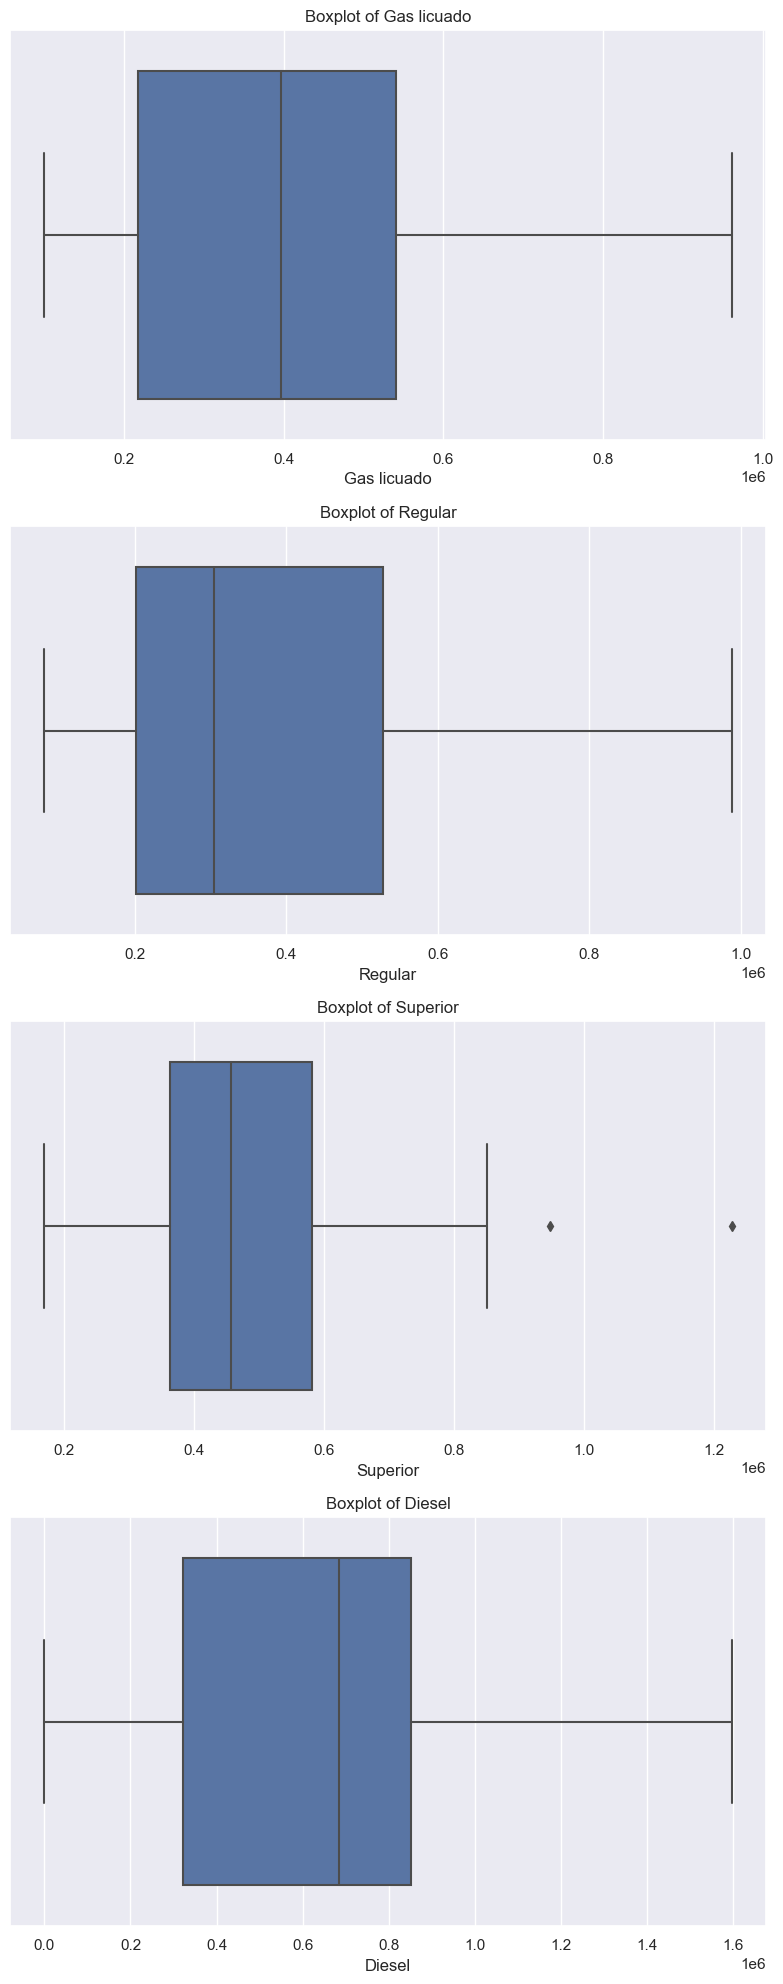

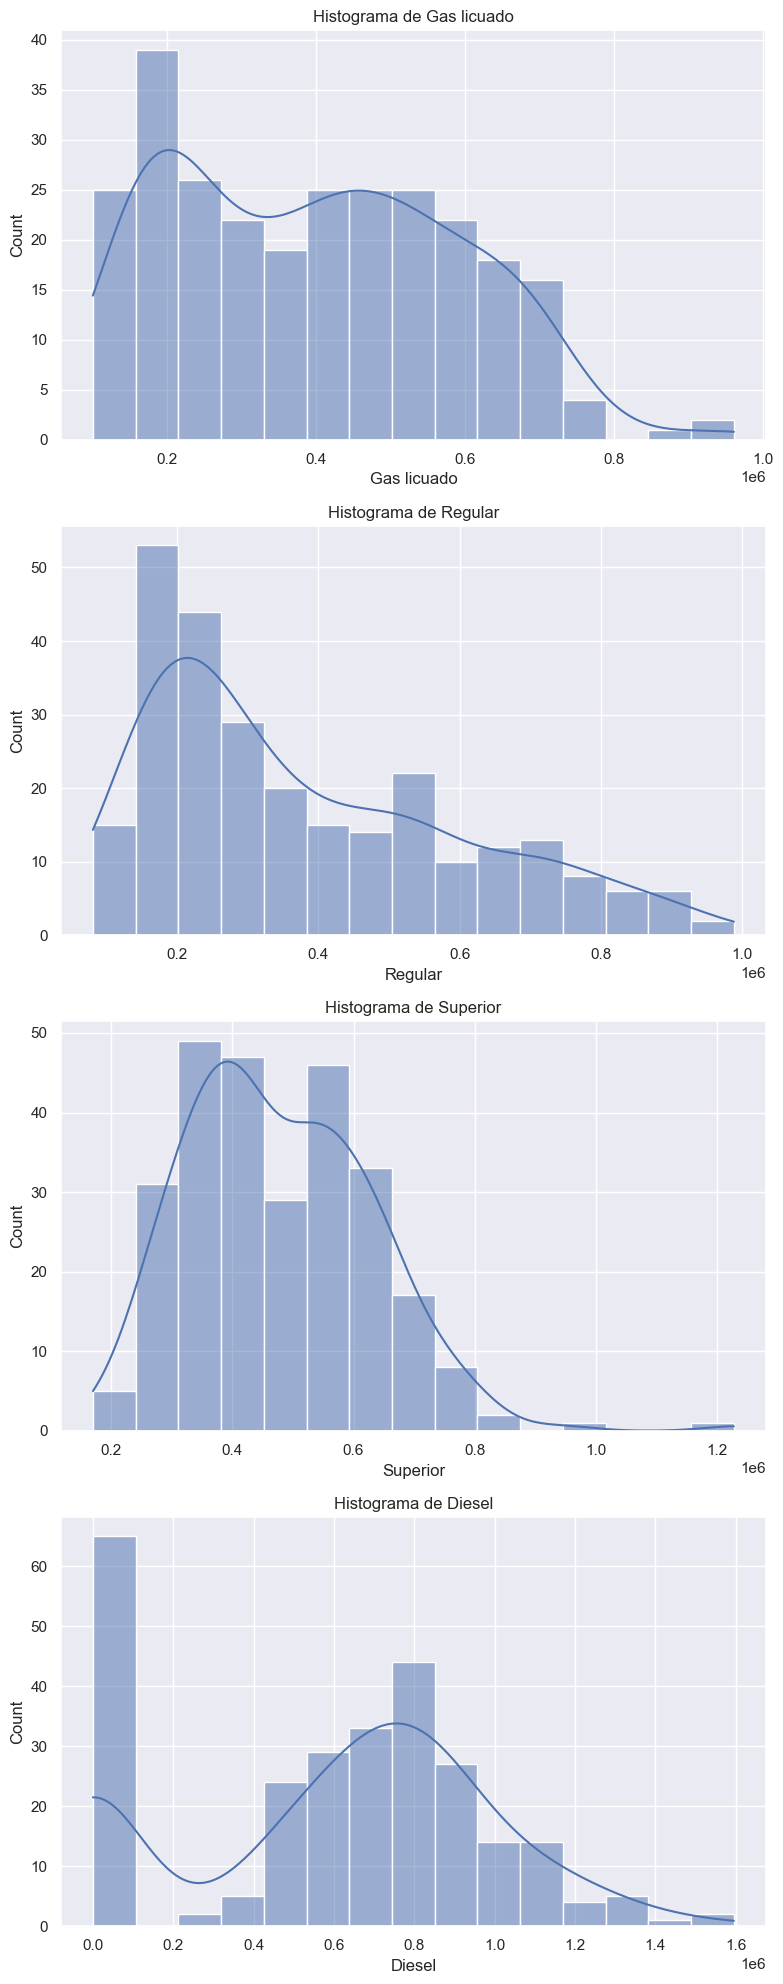

---------------------Consumos---------------------


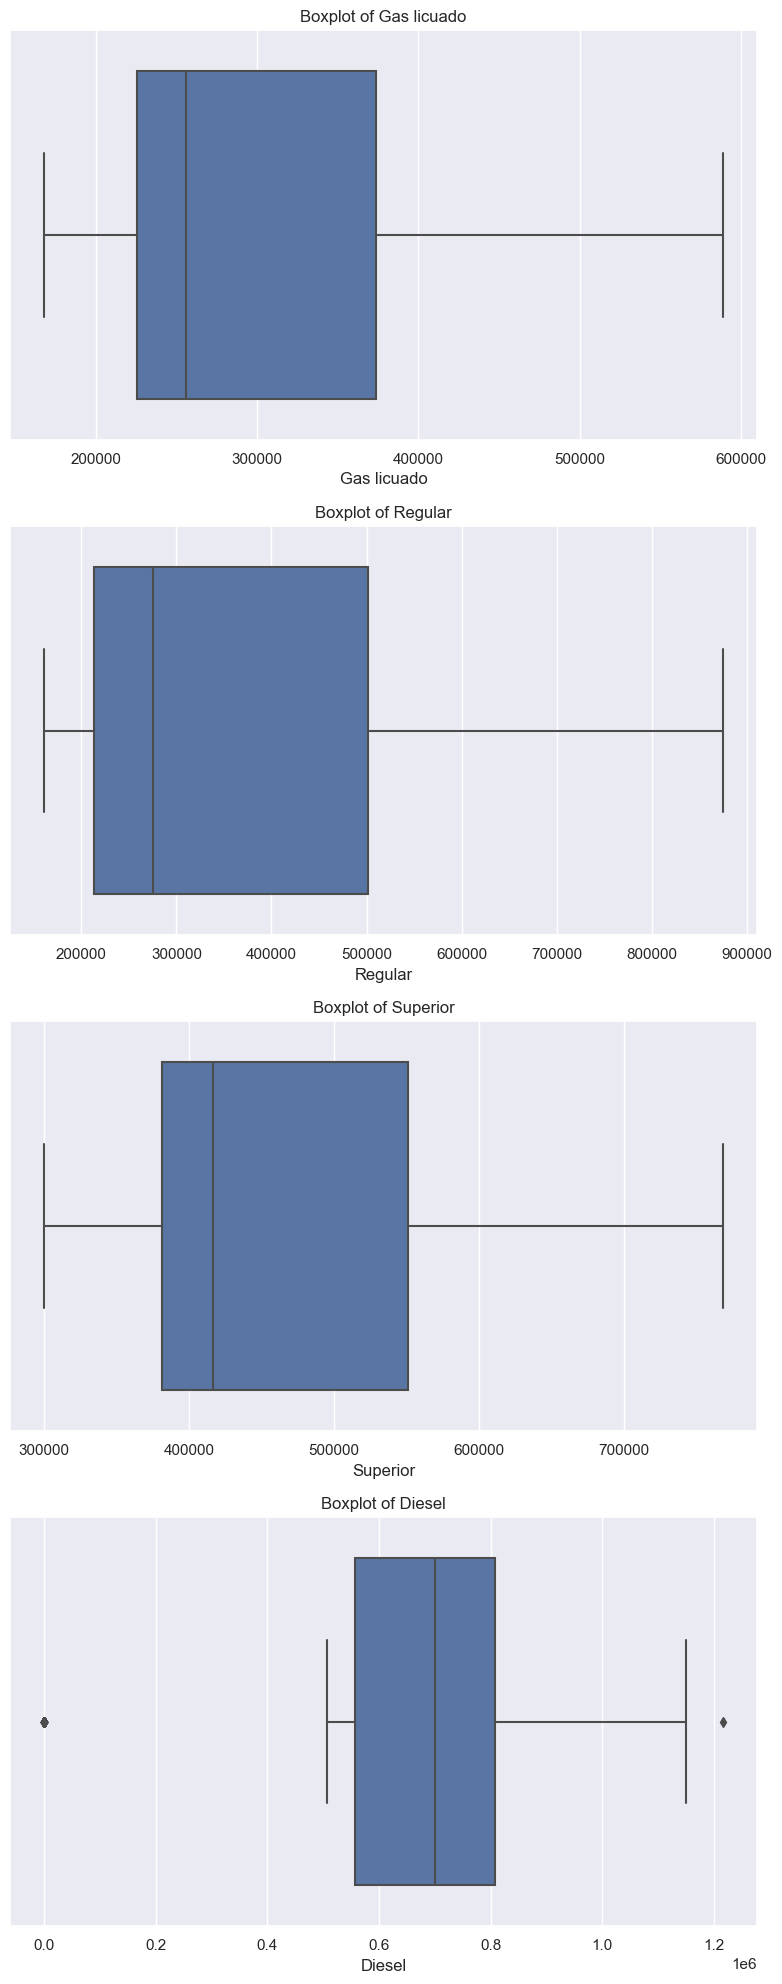

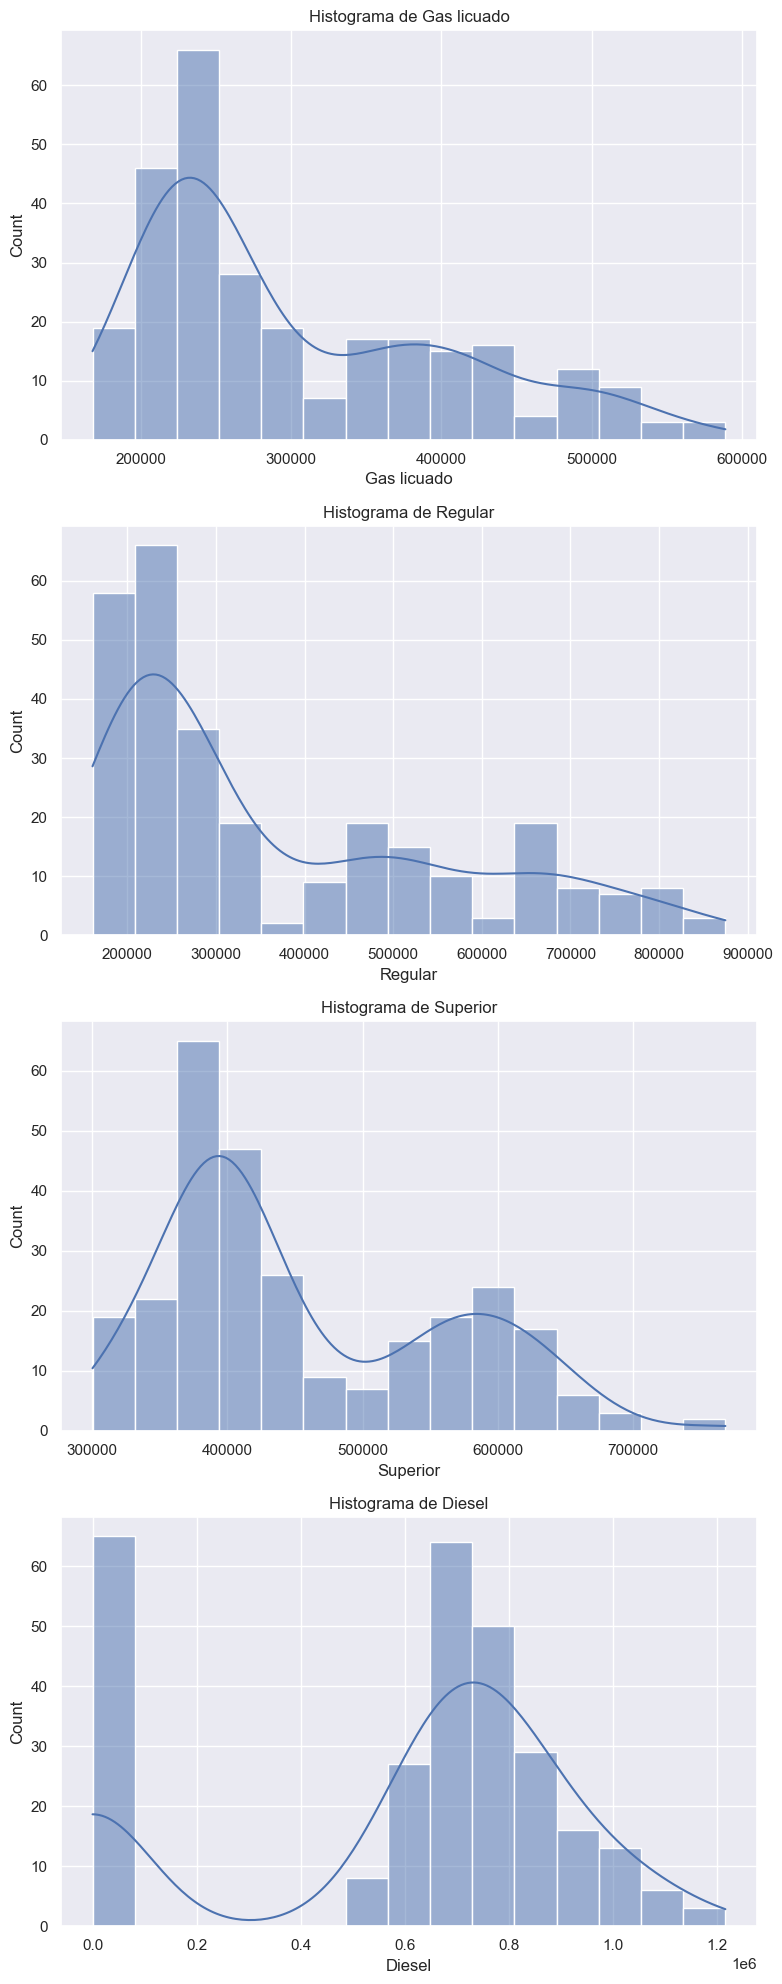

---------------------Precios----------------------


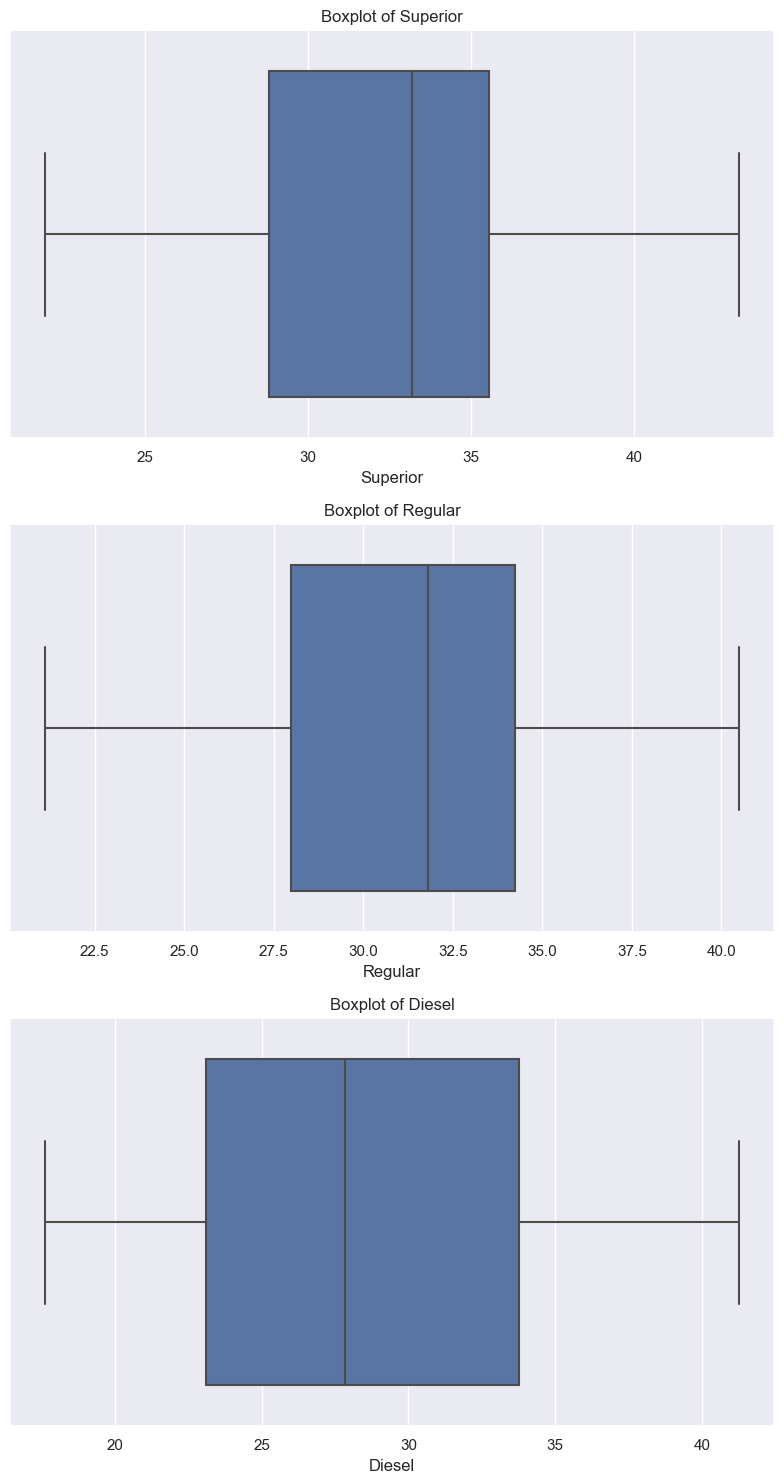

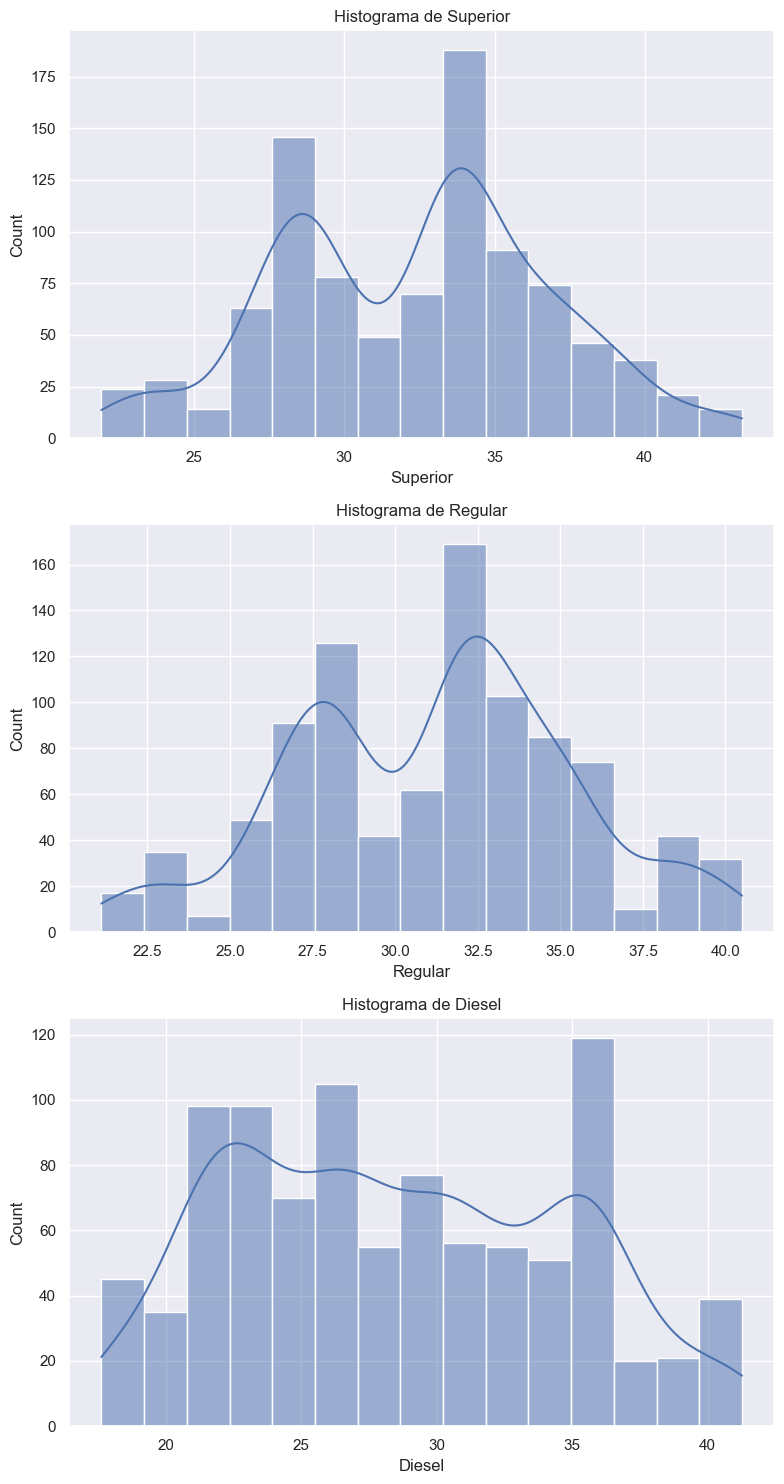

In [4]:
   
def get_numeric_columns(dataframe: pd.DataFrame) -> list[str]:
    """Gets the names of all numeric columns in the dataframe.

    Args:
        dataframe (pd.Dataframe): A pandas DataFrame.

    Returns:
        List<str>: List of column names that are numeric.
    """
    
    return dataframe.select_dtypes(include=['number']).columns.tolist()

def get_categorical_columns(dataframe):
    """Gets the names of all categoric columns in the dataframe.

    Args:
        dataframe (pd.Dataframe): A pandas DataFrame.

    Returns:
        List<str>: List of column names that are categoric.
    """
    return dataframe.select_dtypes(include=['object']).columns.tolist()

def exploration(dataframe: pd.DataFrame, categorical = False) -> None:
    
    numeric = get_numeric_columns(dataframe)
    n_num = len(numeric)
    
    _, axes = plt.subplots(n_num, 1, figsize=(8, 5 * n_num)) 
    
    for var, ax in zip(numeric, axes):
        sns.boxplot(x=dataframe[var], ax=ax)
        ax.set_title('Boxplot of ' + var)

    plt.tight_layout()
    
    _, axes = plt.subplots(n_num, 1, figsize=(8, 5 * n_num))
    
    for var, ax in zip(numeric, axes):
        sns.histplot(dataframe[var], kde=True, ax=ax, bins=15)
        ax.set_title('Histograma de ' + var)
        
    plt.tight_layout()
    
    plt.show()
    
    if not categorical:
        return None
    
    for x in get_categorical_columns(dataframe):
        eda_cat(dataframe, x)

for x in dataframes:
    print(x.name.center(50, '-'))
    exploration(x)

# Analisis Especifico

---------------------Importes---------------------
GAS____________MES
Gas licuado    ene
Regular        mar
Superior       mar
Diesel         dic
dtype: object
GAS____________ANO
Gas licuado    22
Regular        22
Superior       21
Diesel         16
dtype: object


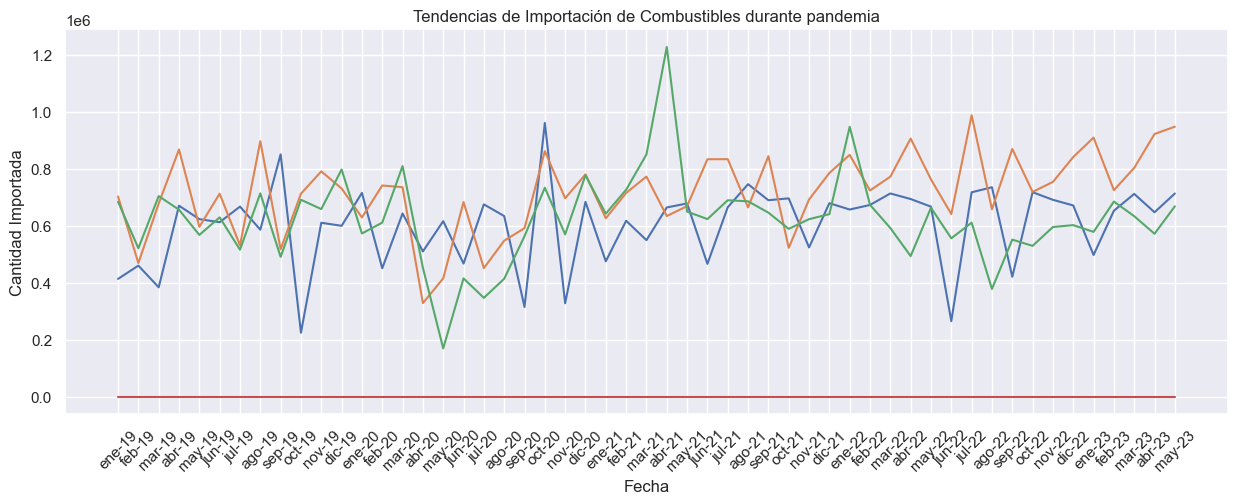

---------------------Consumos---------------------
GAS____________MES
Gas licuado    mar
Regular        dic
Superior       dic
Diesel         mar
dtype: object
GAS____________ANO
Gas licuado    22
Regular        22
Superior       21
Diesel         17
dtype: object


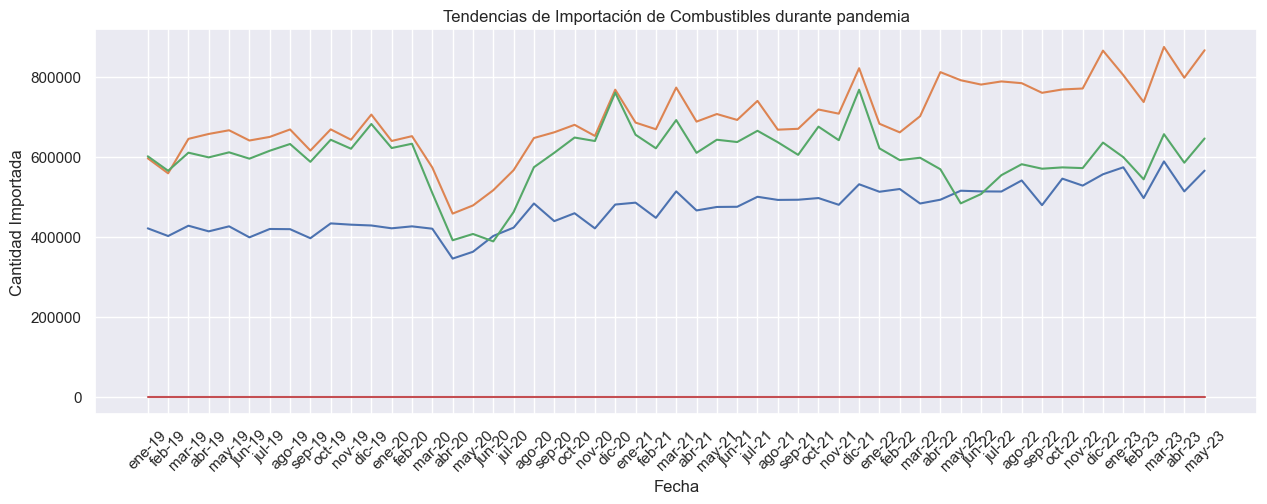

---------------------Precios----------------------
GAS____________MES
Superior    may
Regular     may
Diesel      mar
dtype: object
GAS____________ANO
Superior    2022
Regular     2022
Diesel      2022
dtype: object


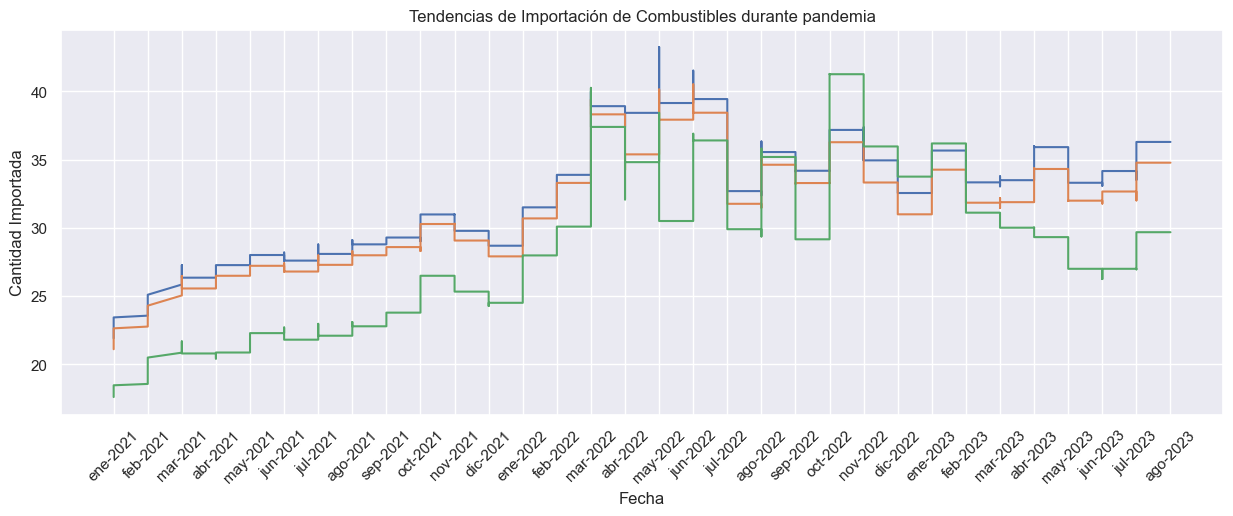

In [5]:
def tendencias(dataframe):
    importes_mensuales = dataframe.groupby('Mes').sum(numeric_only=True).reset_index()
    maximos_x_gas = importes_mensuales.set_index('Mes').idxmax()
    print("GAS____________MES")
    print(maximos_x_gas)

    importes_mensuales = dataframe.groupby('Año').sum(numeric_only=True).reset_index()
    maximos_x_gas = importes_mensuales.set_index('Año').idxmax()
    print("GAS____________ANO")
    print(maximos_x_gas)
       
       
    plt.figure(figsize=(15, 5))
    df_pandemic = dataframe[dataframe['Año'].astype(int) >= 19]
    for column in df_pandemic.select_dtypes(include=['number']).columns:
        plt.plot(df_pandemic['Mes'] + '-' + df_pandemic['Año'], df_pandemic[column], label=column)
    plt.title("Tendencias de Importación de Combustibles durante pandemia")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad Importada")
    plt.xticks(rotation=45)
    plt.show()

    
for x in dataframes:
    print(x.name.center(50, "-"))
    tendencias(x)

# Se trabajara con:
- Consumo de Superior Mensual
- Importacion de Gas Licuado Mensual
- Precios de Superior Mensual

# Graficos de Serie
## Especificar Inicio, fin y frecuencia

In [6]:
def date_range(dataframe):
    inicio = dataframe['Año'].min() + '-' + dataframe[dataframe['Año'] == dataframe['Año'].min()]['Mes'].min()
    fin = dataframe['Año'].max() + '-' + dataframe[dataframe['Año'] == dataframe['Año'].max()]['Mes'].max()
    frecuencia = "Diario" if dataframe.name == 'Precios' else "Mensual"

    print(inicio, fin, frecuencia)

for x in dataframes:
    print(x.name.center(50, '-'))
    date_range(x)


---------------------Importes---------------------
01-abr 23-may Mensual
---------------------Consumos---------------------
00-abr 23-may Mensual
---------------------Precios----------------------
2021-abr 2023-may Diario


## Grafico de serie

---------------------Importes---------------------


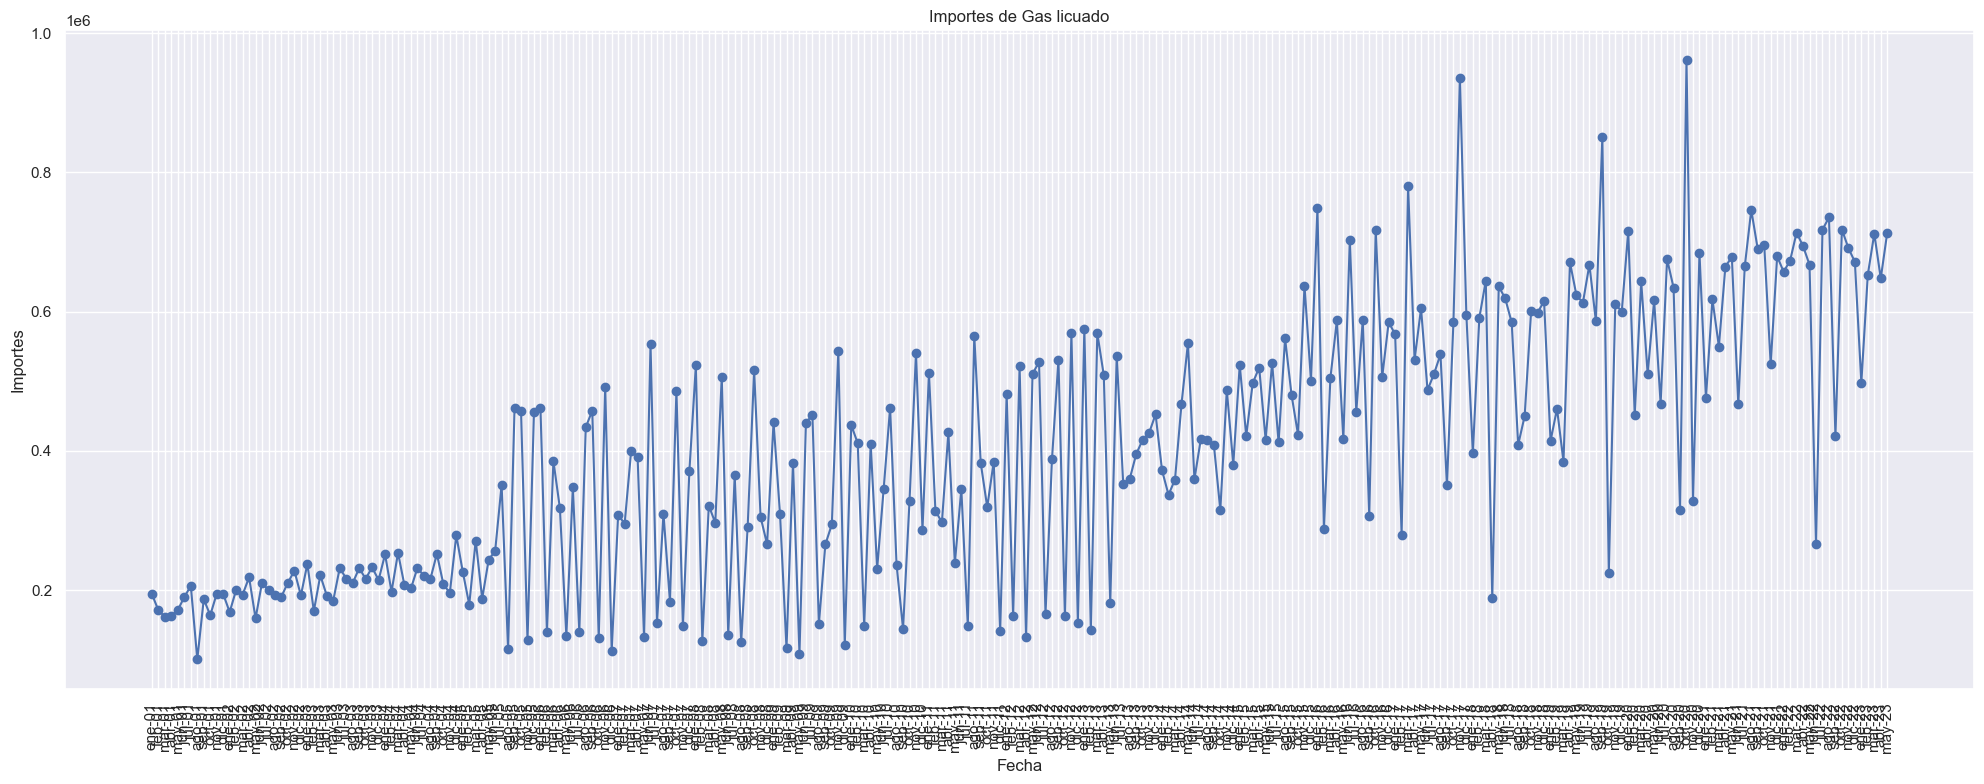

---------------------Consumos---------------------


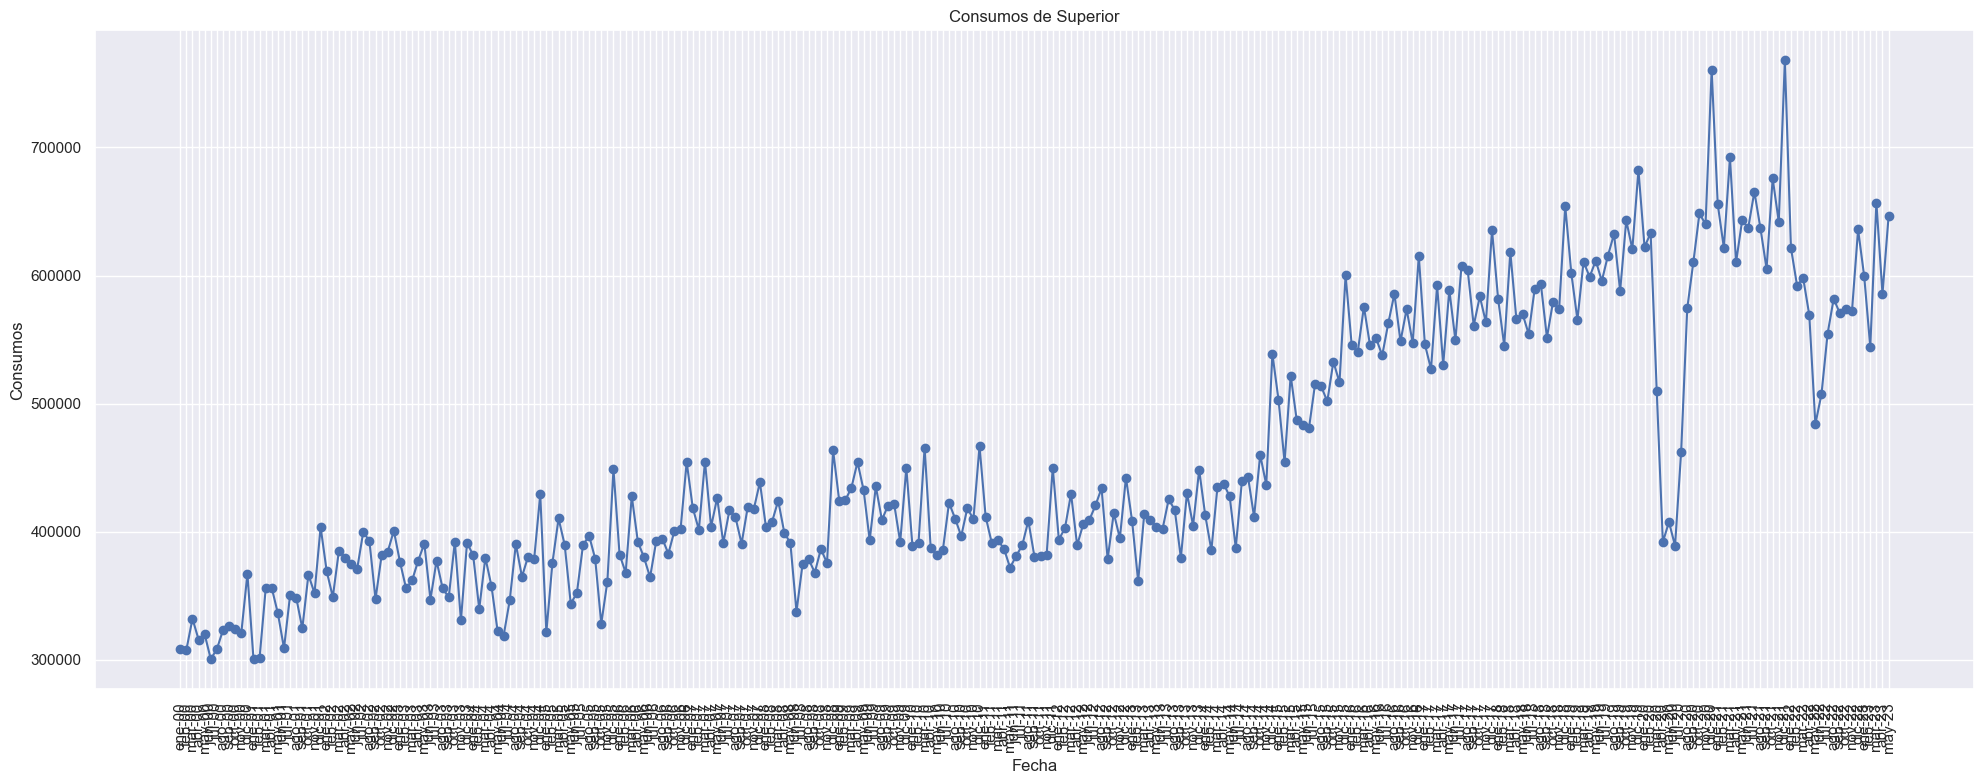

---------------------Precios----------------------


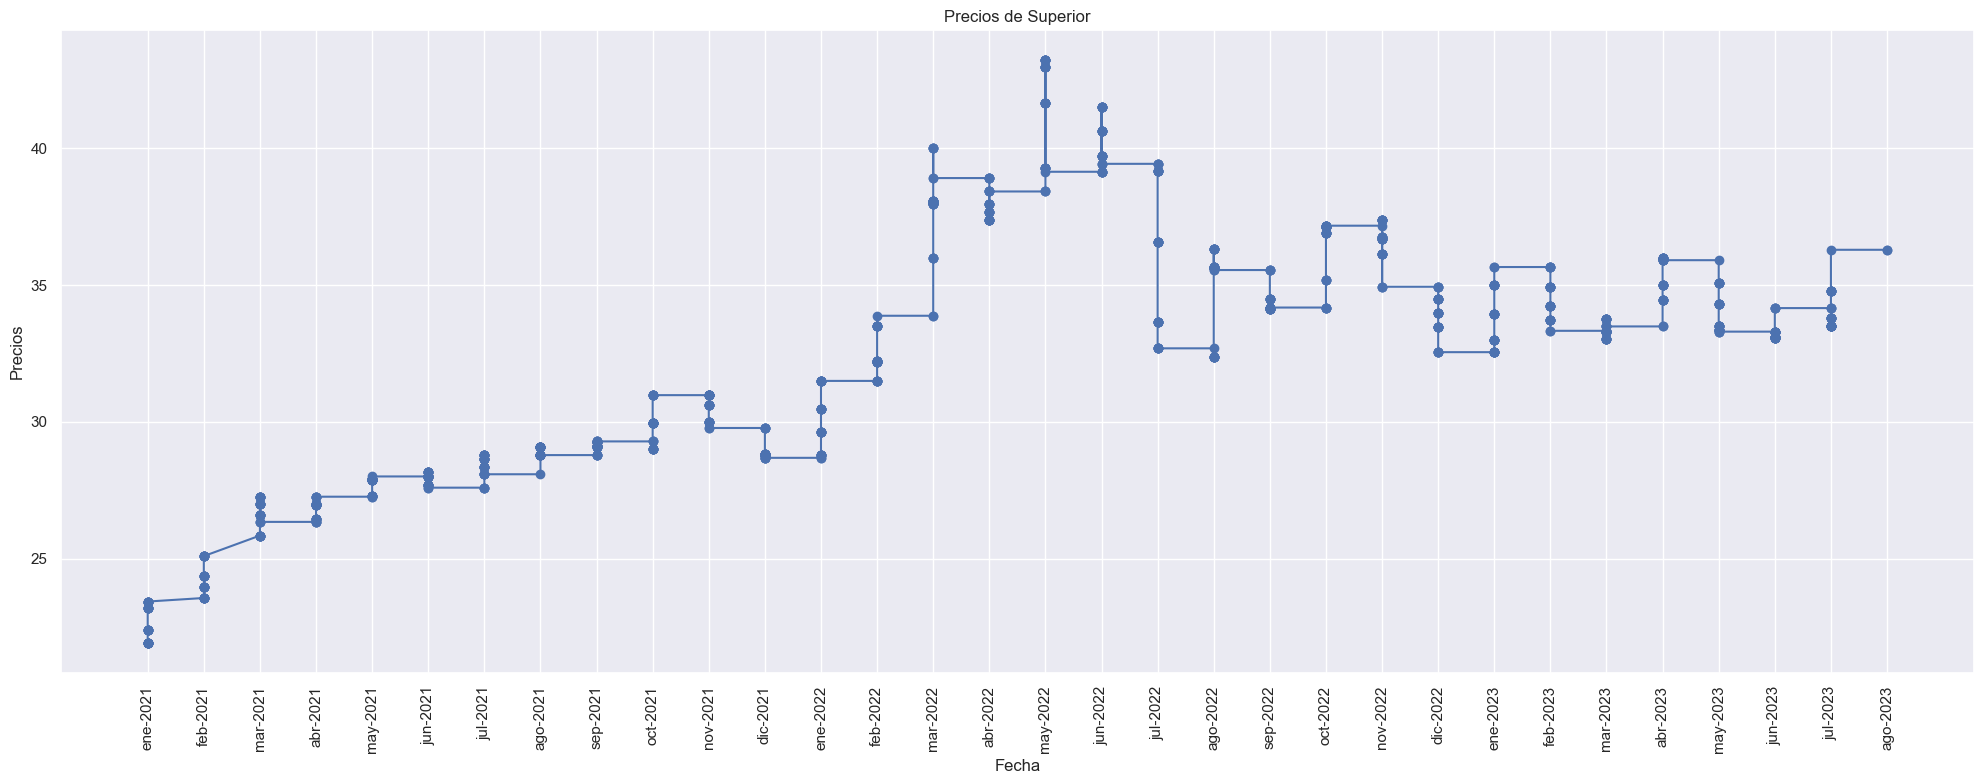

In [7]:
def serie_graph(dataframe, y = 'Superior',):
    plt.figure(figsize=(20, 8))
    plt.plot(dataframe['Mes'] + '-' + dataframe['Año'], dataframe[y], label=y, marker='o')
    plt.title(dataframe.name + " de " + y)
    plt.xlabel("Fecha")
    plt.ylabel(dataframe.name)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

print(importes.name.center(50, '-'))
serie_graph(importes, 'Gas licuado')
print(consumos.name.center(50, '-'))
serie_graph(consumos, 'Superior')
print(precios.name.center(50, '-'))
serie_graph(precios, 'Superior')


### Observaciones
#### Importes
- Tendencia: Se observa una tendencia al alza en las importaciones de gas licuado a lo largo de los años.
- Estacionalidad: Parece haber un patrón estacional en las importaciones, con picos y caídas recurrentes a lo largo de cada año.
- Variabilidad: Aunque hay un patrón generalmente creciente, también hay variabilidad en las importaciones de mes a mes.
#### Consumos
- Tendencia: Se observa una tendencia al alza en el consumo de superior, sin embargo se puede notar fuertemente la influencia de la pandemia con una caida significativa.
- Estacionalidad: No parece haber un patron fuerte que se presente anualmente en los datos.
- Variabilidad: Se nota una variablidad mes a mes en los datos, sin embargo no es tan marcada como en las importaciones.
#### Precios
- Tendencia: Se observa una tendencia al alza en el el precio, que ultimamente se ha visto frenada.
- Estacionalidad:No parece haber una fuerte estacionalidad en los datos, asimismo con solo 3 anos no se puede ver una estacionalidad marcada.
- Variabilidad: Se nota que si hay variabilidad en los datos, dado a que depende fuertemente de los precios internacionales del petroleo, asimismo se nota una mayor variabilidad luego del inicio del conflicto ucraniano.

---------------------Importes---------------------


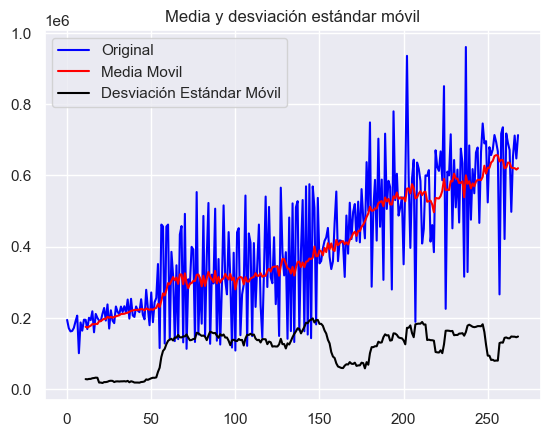

---------------------Consumos---------------------


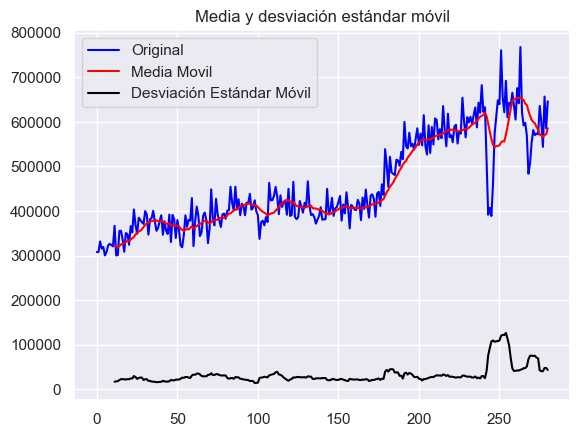

---------------------Precios----------------------


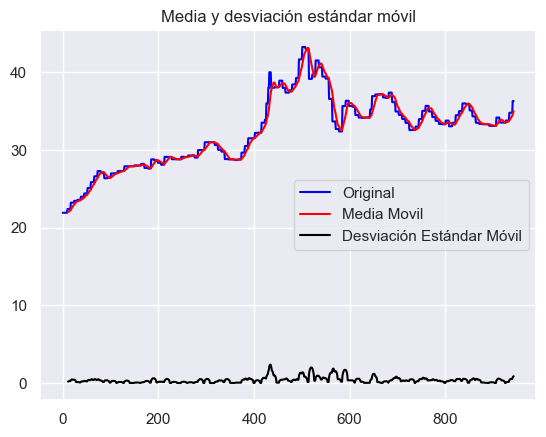

In [13]:
def mediaMovil(dataframe, columna):
    # Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
    mediaMovil = dataframe[columna].rolling(window=12).mean()
    deMovil = dataframe[columna].rolling(window=12).std()
    # Se grafican los resultados.
    original = plt.plot(dataframe[columna], color="blue", label="Original")
    media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
    ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
    plt.legend(loc = 'best')
    plt.title('Media y desviación estándar móvil')
    plt.show(block=False)
    
print(importes.name.center(50, '-'))
mediaMovil(importes, 'Gas licuado')
print(consumos.name.center(50, '-'))
mediaMovil(consumos, 'Superior')
print(precios.name.center(50, '-'))
mediaMovil(precios, 'Superior')

## Estimar las variables

In [17]:
def dickFulley(dataframe, columna):
    print('Resultados del Test de Dickey Fuller')
    dfTest = adfuller(dataframe[columna], autolag='AIC')
    salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
    for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
    print(salidaDf)

print(importes.name.center(50, '-'))
dickFulley(importes, 'Gas licuado')
print(consumos.name.center(50, '-'))
dickFulley(consumos, 'Superior')
print(precios.name.center(50, '-'))
dickFulley(precios, 'Superior')

---------------------Importes---------------------
Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.504176
p-value                        0.891199
# de retardos usados           9.000000
# de observaciones usadas    259.000000
Critical Value (1%)           -3.455853
Critical Value (5%)           -2.872765
Critical Value (10%)          -2.572752
dtype: float64
---------------------Consumos---------------------
Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.914376
p-value                        0.783201
# de retardos usados          12.000000
# de observaciones usadas    268.000000
Critical Value (1%)           -3.454988
Critical Value (5%)           -2.872386
Critical Value (10%)          -2.572549
dtype: float64
---------------------Precios----------------------
Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.350907
p-value                        0.156074
# de retardos usados           7.000000
# de observaciones usadas 

## Autocorrelacion

---------------------Importes---------------------


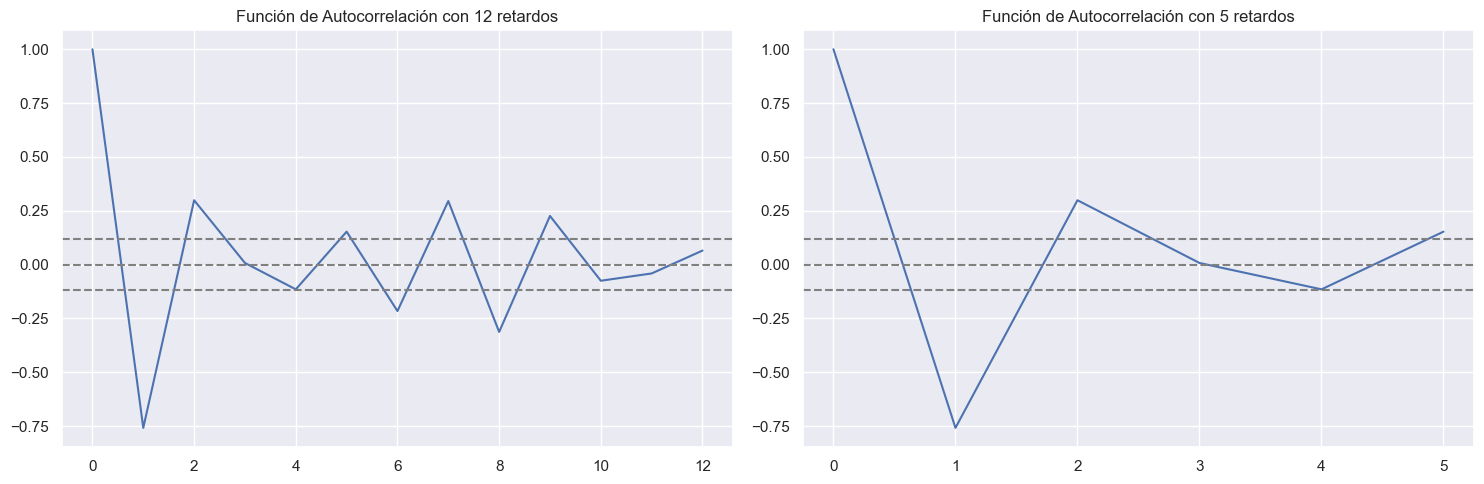

---------------------Consumos---------------------


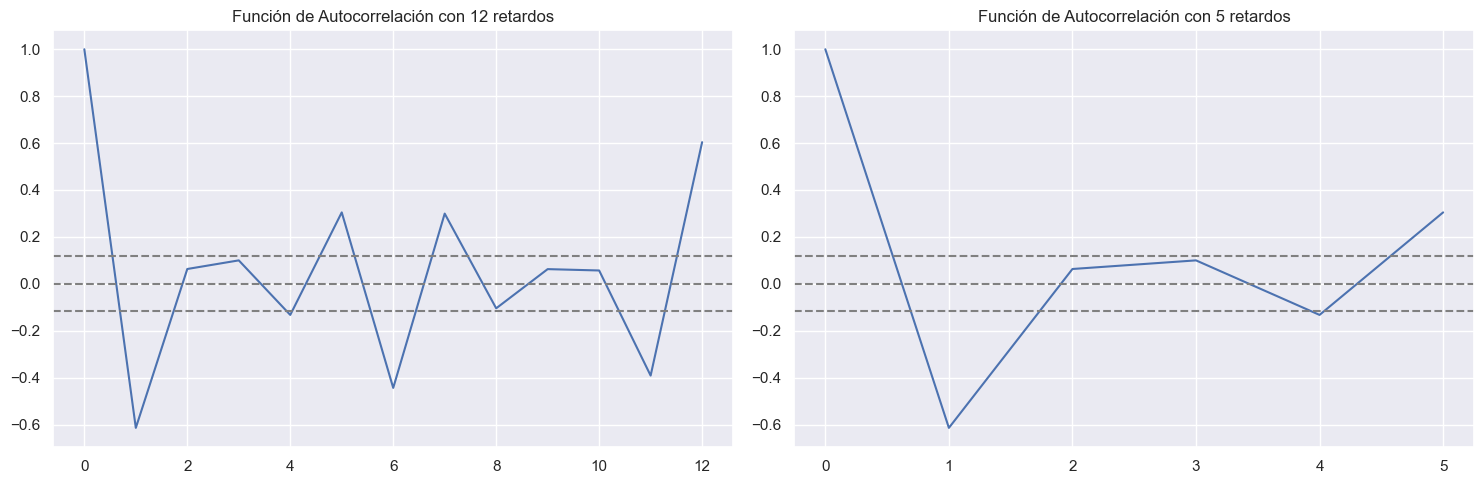

---------------------Precios----------------------


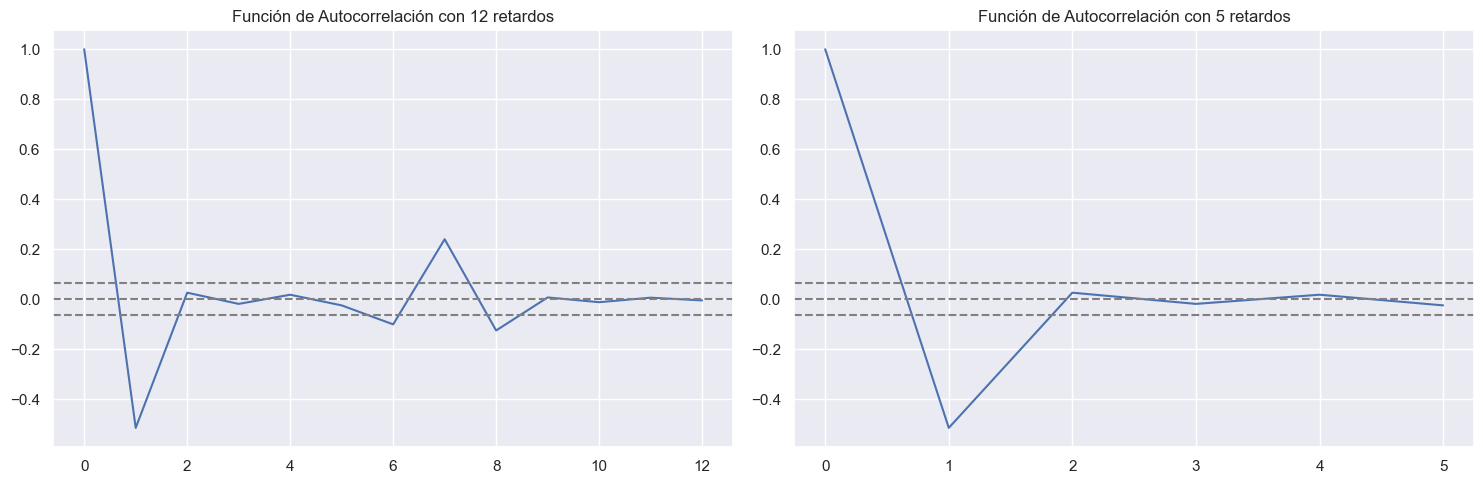

In [22]:
def autocorrelacion(dataframe, columna):
    ts_air_pas_log = np.log(dataframe[columna])
    ts_air_pas_log_diff = ts_air_pas_log.diff().diff()
    ts_air_pas_log_diff.dropna(inplace = True)
    tsa_acf = acf(ts_air_pas_log_diff,nlags=5,fft=False)
    tsa_pacf = pacf(ts_air_pas_log_diff, nlags=36)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    plt.subplot(121) 
    plt.plot(acf(ts_air_pas_log_diff,nlags=12,fft=False))
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
    plt.title('Función de Autocorrelación con 12 retardos')

    plt.subplot(122) 
    plt.plot(acf(ts_air_pas_log_diff,nlags=5,fft=False))
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
    plt.title('Función de Autocorrelación con 5 retardos')

    plt.tight_layout()
    plt.show()
    
print(importes.name.center(50, '-'))
autocorrelacion(importes, 'Gas licuado')
print(consumos.name.center(50, '-'))
autocorrelacion(consumos, 'Superior')
print(precios.name.center(50, '-'))
autocorrelacion(precios, 'Superior')

---------------------Importes---------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6700      0.044    -15.132      0.000      -0.757      -0.583
ma.L1         -1.0000    217.320     -0.005      0.996    -426.939     424.939
ar.S.L12      -0.6408      0.054    -11.887      0.000      -0.746      -0.535
ar.S.L24      -0.3318      0.066     -5.006      0.000      -0.462      -0.202
sigma2         0.3009     65.392      0.005      0.996    -127.865     128.467
Modelo (1, 2, 1)= 391.7542057960437 408.9446023406597


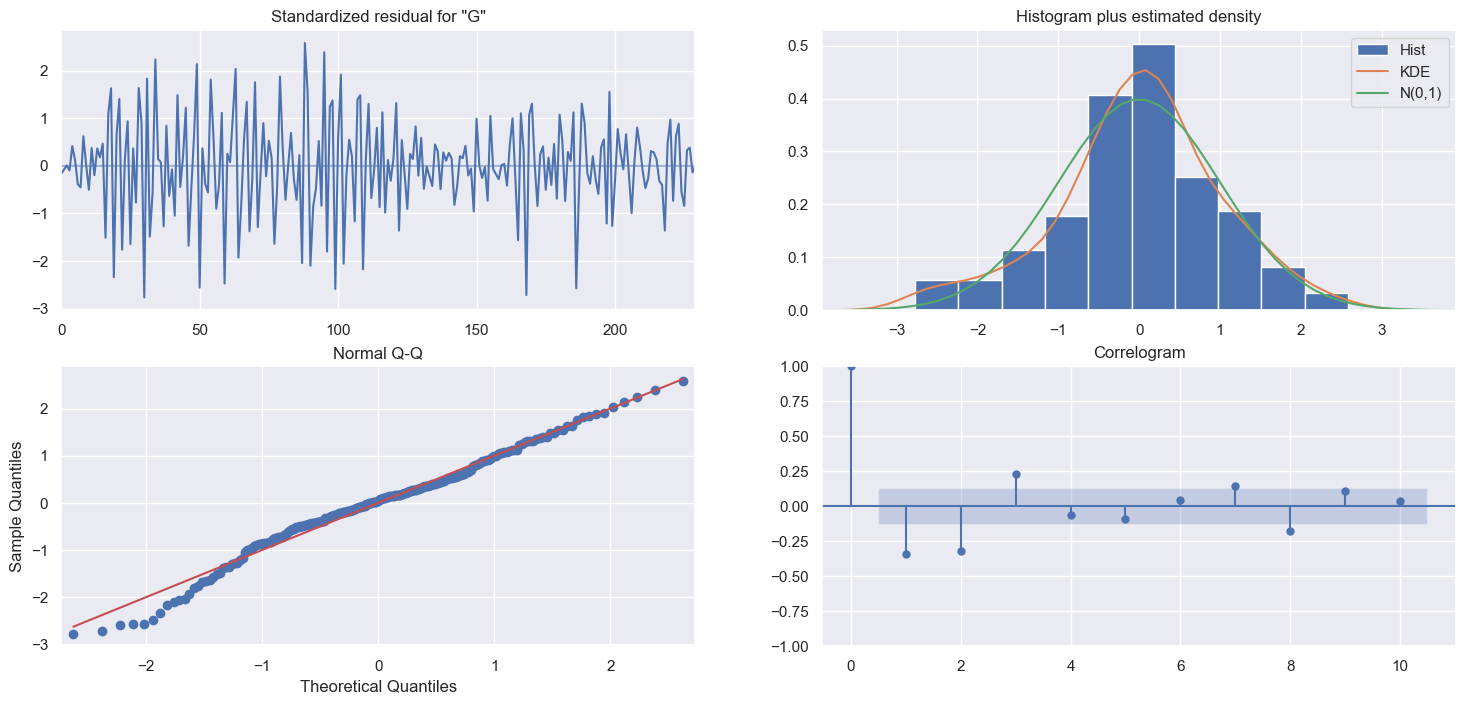

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5472      0.065     -8.390      0.000      -0.675      -0.419
ar.L2         -0.2012      0.064     -3.161      0.002      -0.326      -0.076
ma.L1         -1.9278      7.503     -0.257      0.797     -16.633      12.777
ma.L2          0.9278      6.959      0.133      0.894     -12.712      14.567
ar.S.L12      -0.6606      0.057    -11.585      0.000      -0.772      -0.549
ar.S.L24      -0.3371      0.068     -4.982      0.000      -0.470      -0.204
sigma2         0.1542      1.158      0.133      0.894      -2.116       2.424
Modelo (2, 2, 2)= 246.52672464276475 270.5627786676444


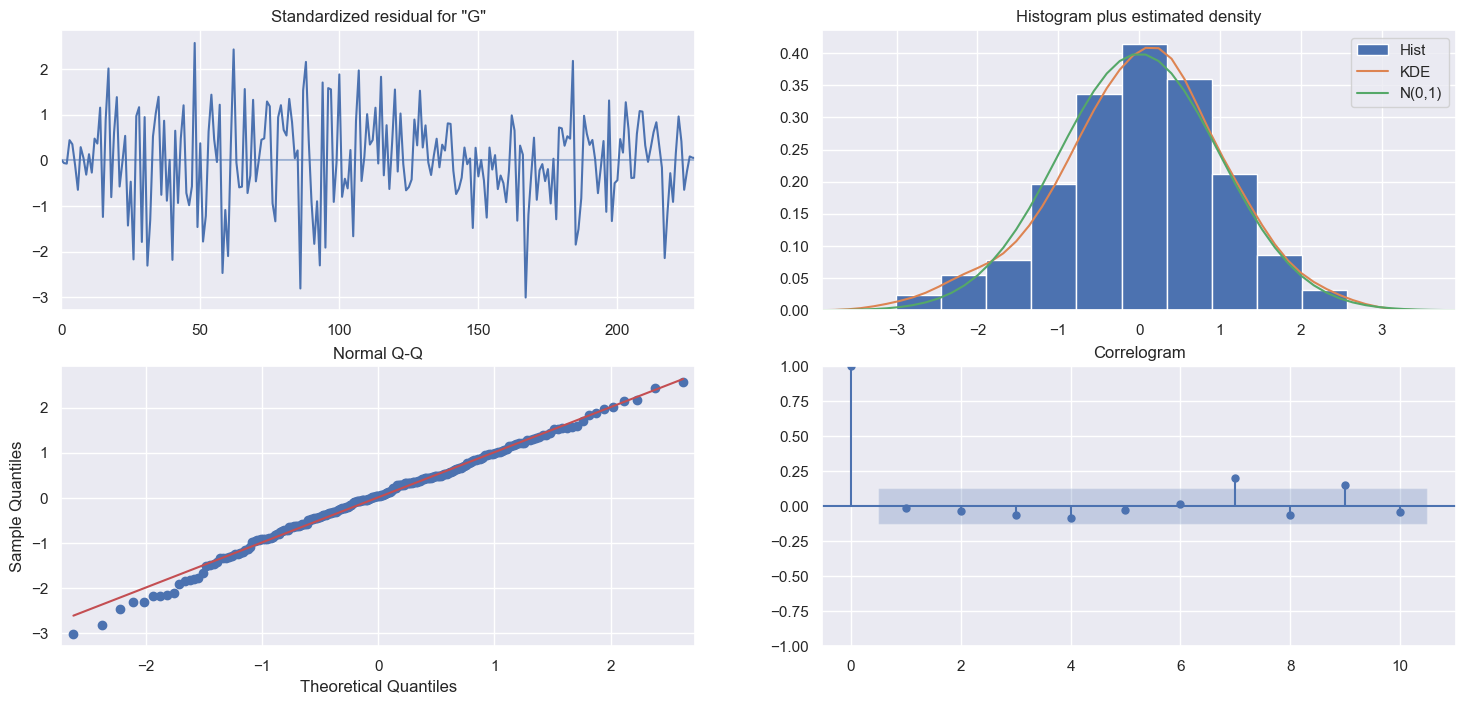

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5421      0.065     -8.401      0.000      -0.669      -0.416
ar.L2         -0.1969      0.064     -3.080      0.002      -0.322      -0.072
ma.L1         -0.9382      0.028    -33.074      0.000      -0.994      -0.883
ar.S.L12      -0.6566      0.057    -11.608      0.000      -0.767      -0.546
ar.S.L24      -0.3335      0.070     -4.774      0.000      -0.470      -0.197
sigma2         0.1534      0.014     11.011      0.000       0.126       0.181
Modelo (2, 1, 1)= 234.98098253025853 255.6094583837977


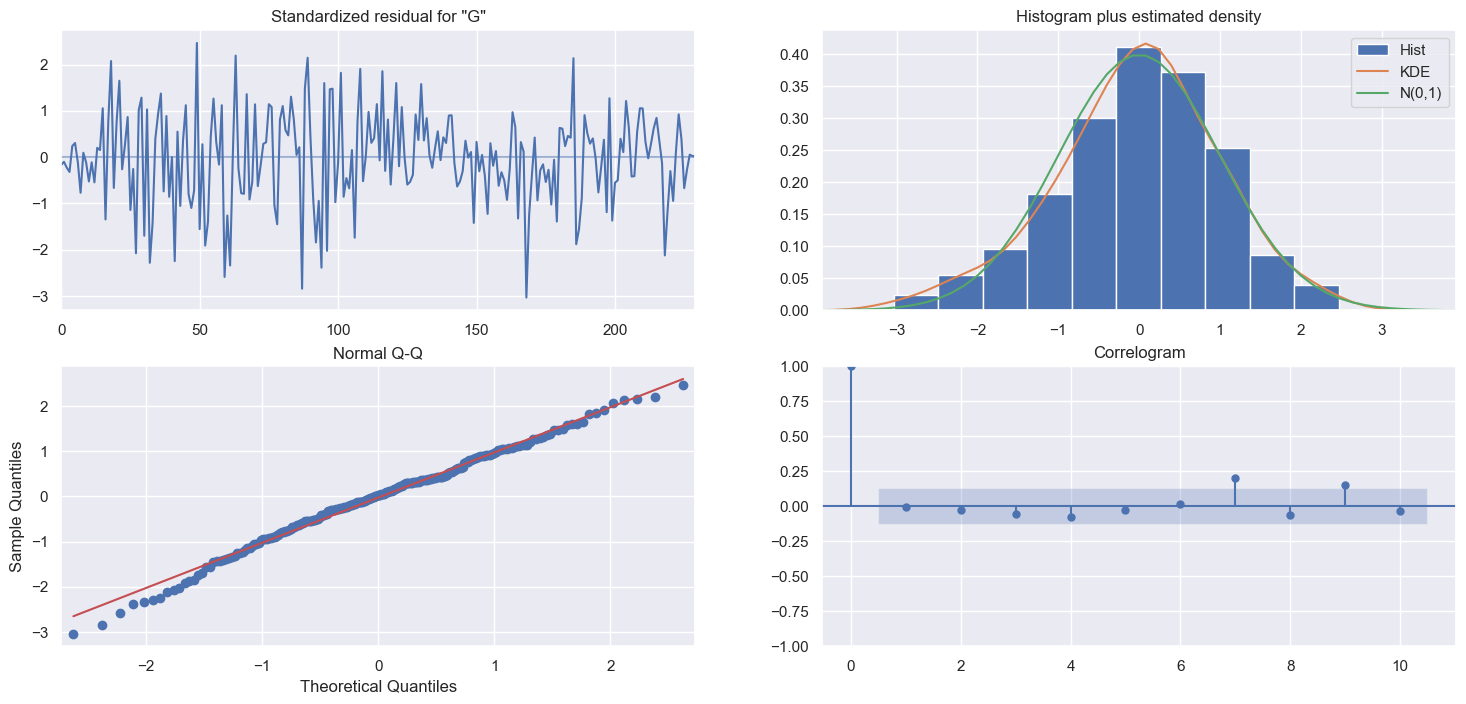

---------------------Consumos---------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2196      0.040     -5.513      0.000      -0.298      -0.142
ma.L1         -1.0000   1403.934     -0.001      0.999   -2752.661    2750.661
ar.S.L12      -0.6720      0.059    -11.350      0.000      -0.788      -0.556
ar.S.L24      -0.3345      0.055     -6.110      0.000      -0.442      -0.227
sigma2         0.0047      6.556      0.001      0.999     -12.844      12.854
Modelo (1, 2, 1)= -597.0091619746078 -579.5644733438244


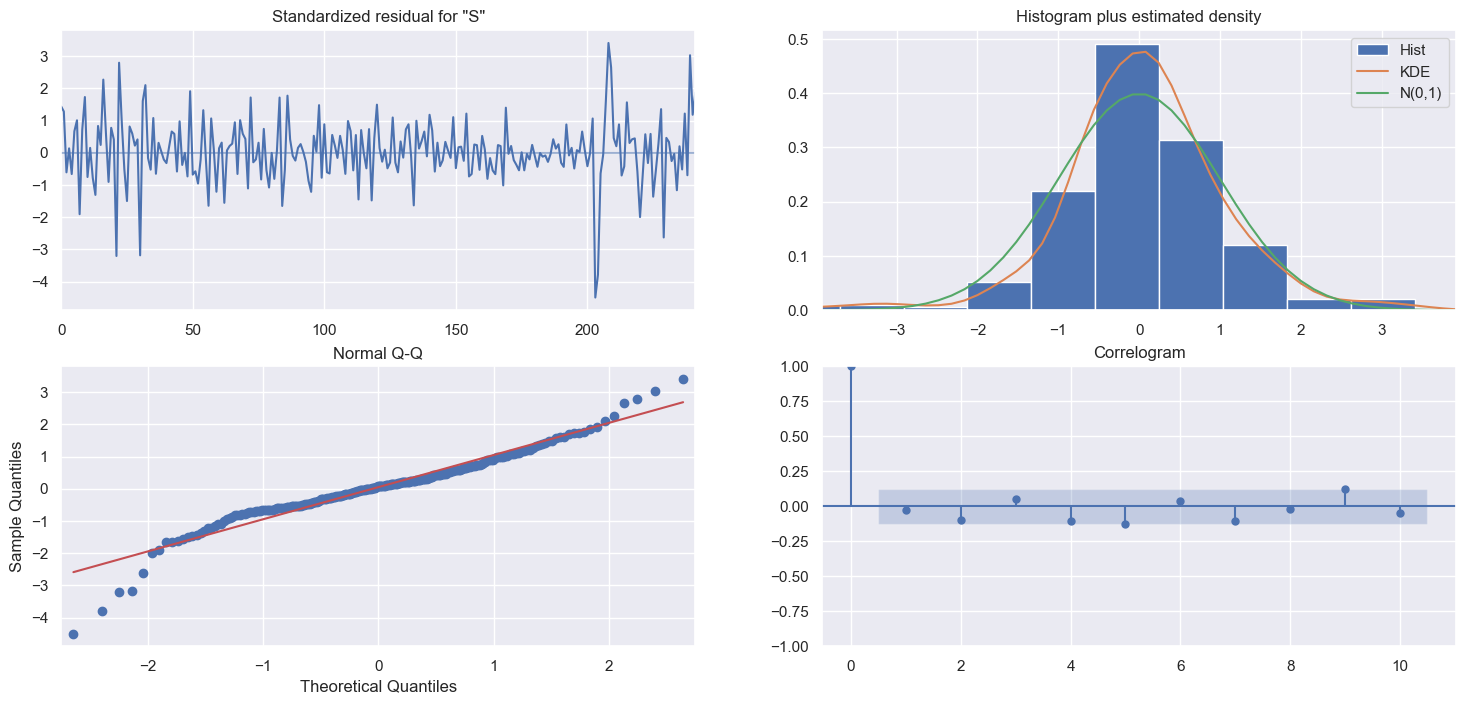

c:\Users\josem\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5692      0.488     -1.167      0.243      -1.525       0.386
ar.L2         -0.2049      0.103     -1.982      0.047      -0.408      -0.002
ma.L1         -0.6663      0.649     -1.026      0.305      -1.939       0.606
ma.L2         -0.3330      0.512     -0.650      0.516      -1.337       0.671
ar.S.L12      -0.7058      0.063    -11.203      0.000      -0.829      -0.582
ar.S.L24      -0.3488      0.057     -6.152      0.000      -0.460      -0.238
sigma2         0.0046      0.002      2.349      0.019       0.001       0.008
Modelo (2, 2, 2)= -596.1417721867515 -571.7481936523169


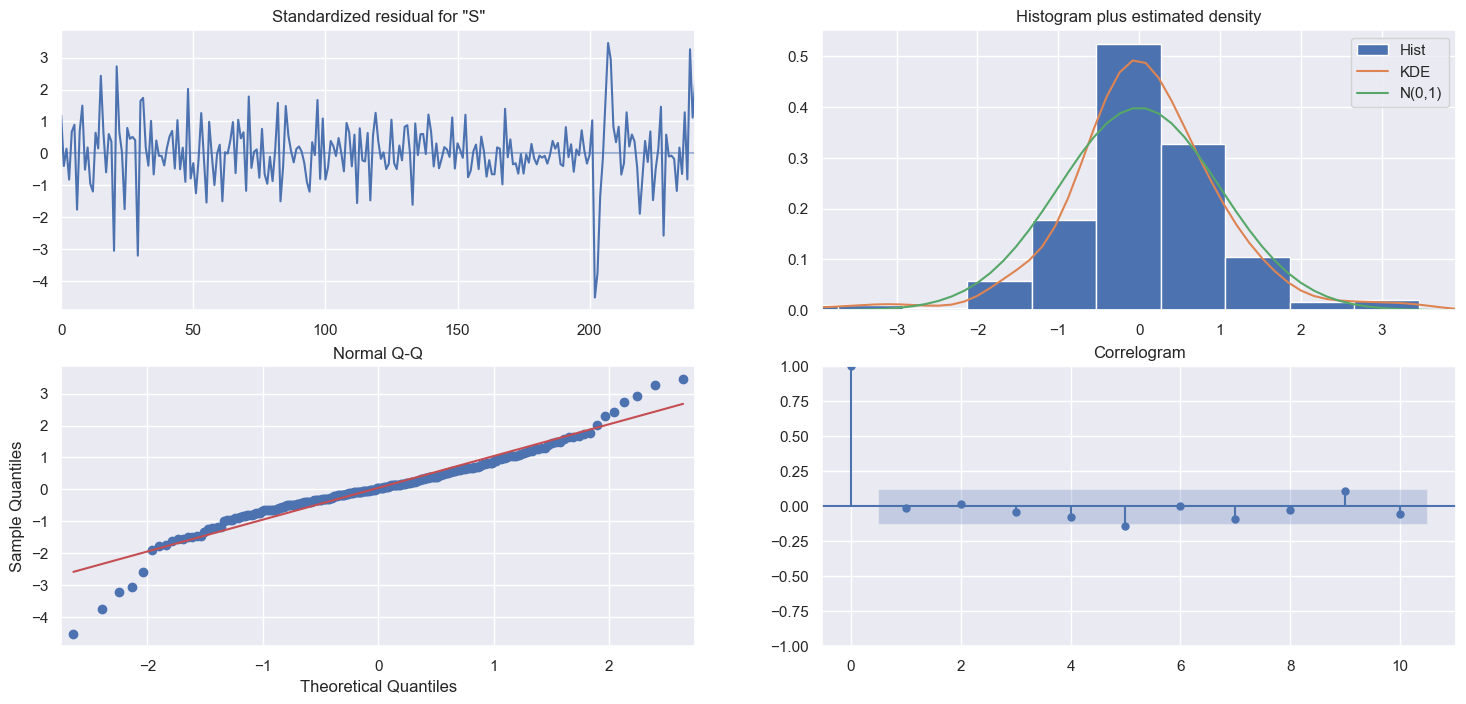

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5269      0.524     -1.006      0.314      -1.553       0.500
ar.L2         -0.1947      0.117     -1.663      0.096      -0.424       0.035
ma.L1          0.2753      0.530      0.520      0.603      -0.763       1.314
ar.S.L12      -0.6999      0.062    -11.278      0.000      -0.821      -0.578
ar.S.L24      -0.3285      0.057     -5.743      0.000      -0.441      -0.216
sigma2         0.0045      0.000     17.695      0.000       0.004       0.005
Modelo (2, 1, 1)= -606.940750113082 -586.0071237561419


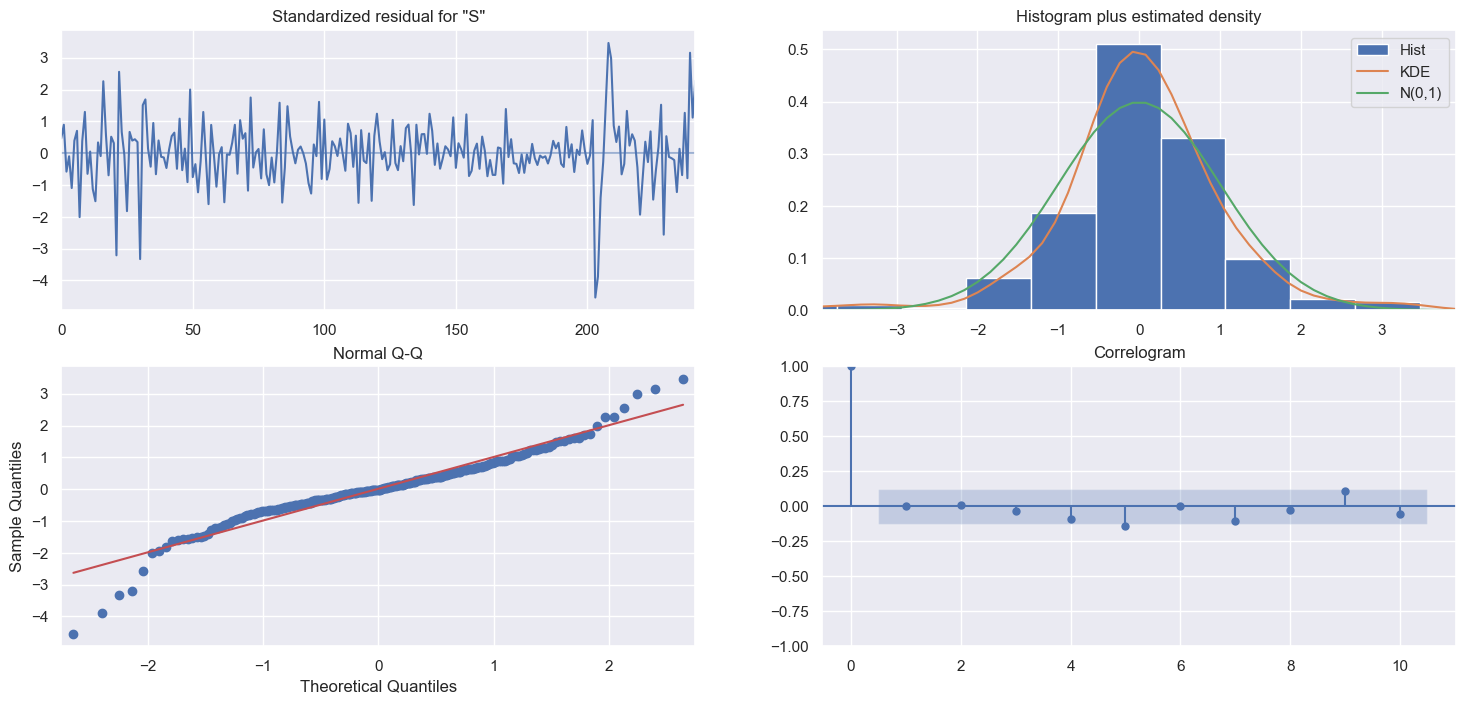

---------------------Precios----------------------


c:\Users\josem\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0090      0.063      0.142      0.887      -0.115       0.133
ma.L1         -1.0000      0.903     -1.108      0.268      -2.770       0.770
ar.S.L12      -0.6742      0.019    -36.117      0.000      -0.711      -0.638
ar.S.L24      -0.3190      0.019    -17.128      0.000      -0.355      -0.282
sigma2         0.0001      0.000      1.103      0.270      -0.000       0.000
Modelo (1, 2, 1)= -5485.048683060803 -5461.009008342304


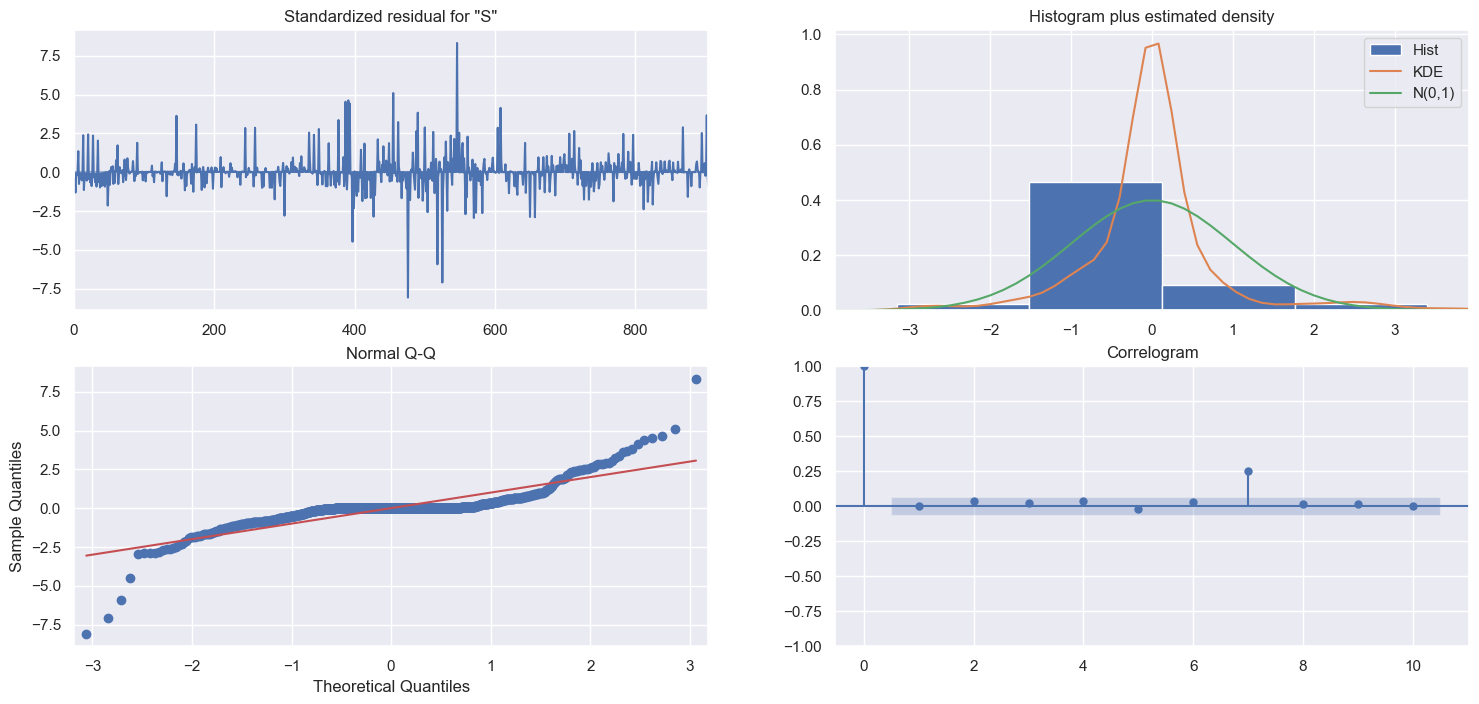

c:\Users\josem\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4744      0.297     -1.596      0.110      -1.057       0.108
ar.L2         -0.1154      0.048     -2.388      0.017      -0.210      -0.021
ma.L1          2.1363      2.513      0.850      0.395      -2.789       7.062
ma.L2         -2.3623      1.985     -1.190      0.234      -6.253       1.529
ar.S.L12      -0.7118      0.019    -36.950      0.000      -0.750      -0.674
ar.S.L24      -0.3236      0.021    -15.608      0.000      -0.364      -0.283
sigma2      1.641e-05    2.8e-05      0.587      0.557   -3.84e-05    7.12e-05
Modelo (2, 2, 2)= -5428.839889368652 -5395.192083845906


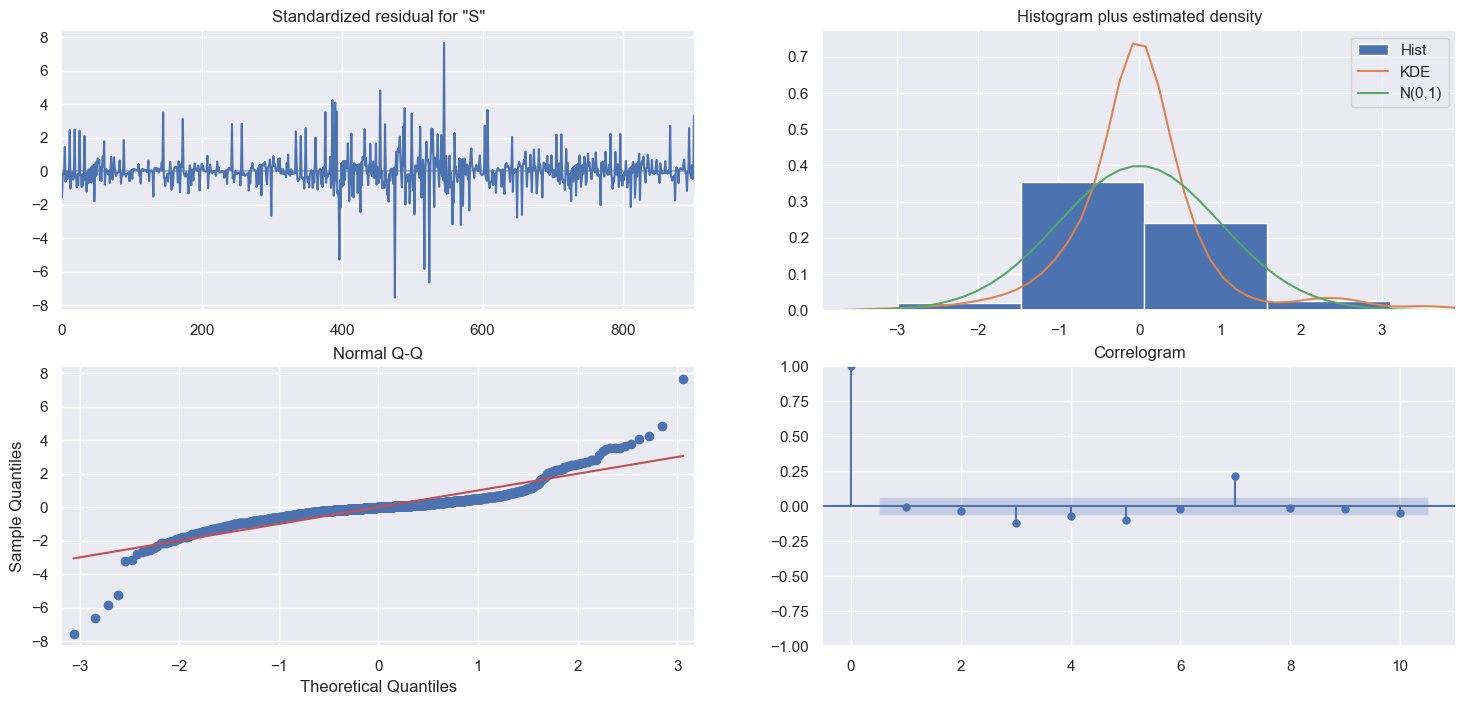

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2986      0.664      0.450      0.653      -1.003       1.601
ar.L2          0.0369      0.037      1.004      0.315      -0.035       0.109
ma.L1         -0.2889      0.663     -0.436      0.663      -1.589       1.011
ar.S.L12      -0.6755      0.019    -36.296      0.000      -0.712      -0.639
ar.S.L24      -0.3185      0.018    -17.391      0.000      -0.354      -0.283
sigma2         0.0001   2.13e-06     62.695      0.000       0.000       0.000
Modelo (2, 1, 1)= -5492.14101257515 -5463.29340291295


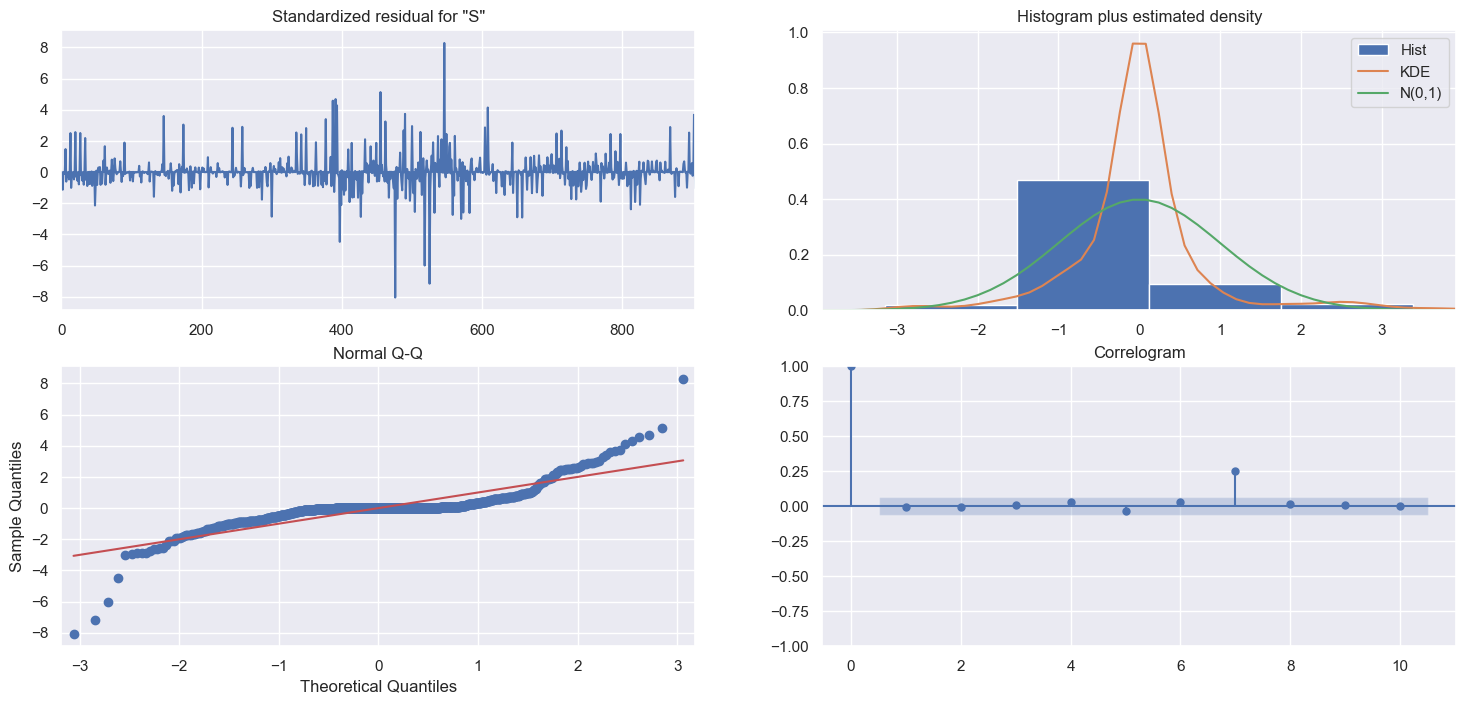

In [32]:
def arima(dataframe, column):
    for meme in [(1,2,1),(2,2,2), (2,1,1)]:
        modelo121 = SARIMAX(np.log(dataframe[column]), order=meme, seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
        resultado_m121 = modelo121.fit()
        print(resultado_m121.summary().tables[1])
        resultado_m121.plot_diagnostics(figsize=(18, 8))
        print(f"Modelo {meme}=",resultado_m121.aic, resultado_m121.bic)
        plt.show()

print(importes.name.center(50, '-'))
arima(importes, 'Gas licuado')
print(consumos.name.center(50, '-'))
arima(consumos, 'Superior')
print(precios.name.center(50, '-'))
arima(precios, 'Superior')

Cuando se trata de encontrar el modelo óptimo para manejar importes, consumos y precios, el enfoque más destacado es el 2,1,1. Este modelo se presenta como una solución equilibrada que considera múltiples aspectos esenciales. La combinación de factores en el formato 2,1,1 muestra su eficacia al tratar con los desafíos complejos de los importes, los patrones de consumo y las dinámicas de precios. Al adoptar esta configuración, se busca lograr una armonía entre las diversas variables involucradas, lo que resulta en un enfoque que puede brindar soluciones más sólidas y precisas en este ámbito.